
<hr style="height: 2px; background: linear-gradient(to right, #E31B1D 50%, #00A4DD 50%);">

<div style="display: flex;">
    
<div style="width: 20%; text-align: left;">
    <img src="logos/hpc_logo.png" alt="HPC logo" width="100px">
</div>

<div style="width: 60%; text-align: center;">
    <strong><center><font size = "6">Array Operations with Python parallel packages in a single node</font></center></strong>
    <br>
    <strong><center><font size = "4">Python + HPC</font></center></strong>
</div>

<div style="width: 20%; text-align: right;display: flex; justify-content: center;align-items: center;">
    <img src="logos/unilu_logo.png" alt="UL logo" width="100px">
</div>
    
</div>

<hr style="height: 2px; background: linear-gradient(to right, #E31B1D 50%, #00A4DD 50%);">

By: **Oscar J. CASTRO-LOPEZ** (oscar.castro@uni.lu)

**University of Luxembourg | HPC | PCOG**

<hr>

## Table of Contents

0. [Workshop Overview](#workshopoverview)
1. [Use case: Euclidean distance](#usecase)
2. [Python Baseline](#python)
3. [Numpy Implementation](#numpy)
4. [Python Multiprocessing](#multiproc)
5. [PyMP](#pymp)
6. [Cython](#cython)
7. [Numba](#numba)
8. [Benchmarking](#benchmarking)
9. [Conclusion](#conclusions)


## 0. Workshop Overview <a name="workshopoverview"></a>

Welcome to the **Python + HPC workshop**. In this interactive session, we will start to explore high-performance computing in Python. We'll optimize Python code using the Euclidean distance measurement algorithm, showcasing the efficiency of map multiprocessing, PyMP, Cython, and Numba versus Numpy. By the end, you'll master Python's potential for high-performance tasks in a **single node**.

### Prerequisites 

Before we begin, please make sure you have the following:

- A basic understanding of Python programming.
- Familiarity with Jupyter Notebook (installed and configured). 
- A basic understanding of Numpy and linear algebra.
- Familiarity of parallel computing.

### Agenda

1. **Use case overview**
2. **Python baseline**
2. **Numpy implementation**
2. **Python Multiprocessing**
3. **PyMP - OpenMP-like**
3. **Cython implementation**
3. **Numba implementation**
3. **Benchmarking**
3. **Conclusion**

### Workshop Key Goals
The primary objectives of this workshop are:

- To provide a basic understanding of parallelizing python code.
- To equip you with practical skills on how to efficiently improve Python code with parallel approach.
- Give a general overview of parallelization tools available in Python's ecosystem.

### Getting Started

To get started with this workshop, follow these steps:

1. Clone or download the workshop materials from the [GitHub repository](https://github.com/ULHPC/python-school).
2. Open a terminal and navigate to the workshop directory.
3. Open this notebook (`3_Edistance_singlenode_parallel.ipynb`) in your browser.

Let's get started!

<hr style="height: 2px; background: linear-gradient(to right, #E31B1D 50%, #00A4DD 50%);">

## 1. Use Case: Euclidean Distance <a name="usecase"></a>
    
In this notebook, the Euclidean distance measurement algorithm is employed as an illustrative example to showcase the effective utilization of map multiprocessing against Numpy.

https://en.wikipedia.org/wiki/Euclidean_distance

The Euclidean distance between two points P = (p1, p2, ..., pn) and Q = (q1, q2, ..., qn) in n-dimensional space is calculated using the following formula:

$$d(P, Q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \ldots + (p_n - q_n)^2}$$

In the formula, $d(P, Q)$ represents the Euclidean distance between points $P$ and $Q$, $\sqrt{\ldots}$ denotes the square root operation, and $(p1 - q1)^2$ represents the squared difference between the corresponding coordinates of the points.

### Generate random data for testing

The following code generates two matrices of random numbers.


In [47]:
import numpy as np
rows = 500 #500
cols = 500 #500
np.random.seed(699)
A = np.random.rand(rows*cols).reshape((rows,cols))
B = np.random.rand(rows*cols).reshape((rows,cols))
print(f'A shape {A.shape}')
print(f'B shape {A.shape}')

A shape (500, 500)
B shape (500, 500)


## 2. Python baseline implementation <a name="python"></a>

To facilitate understanding the implementation a first step-by-step function using only Python is presented. Three loops are required:

- The first loop is used to iterate over each row of matrix1. 
- The second loop is used to iterate over each row of matrix2. 
- The third and most inner loop iterates over the columns (both matrices must have the same number of columns). 

In the inner loop is where the operations difference, squared and sum of values is done. 

Each time the third loop ends, the `sqrt` function is applied to the result and assigned to its index on the output array.

In [48]:
from math import sqrt

def edistance_python(matrix1, matrix2):
    output = np.zeros((matrix1.shape[0], matrix2.shape[0]))
    for i in range(matrix1.shape[0]): # Loop over matrix1 rows
        for j in range(matrix2.shape[0]): # Loop over matrix2 rows
            sum_squared_diff = 0.0
            for k in range(matrix1.shape[1]): # Loop over two matrices columns
                diff = matrix1[i, k] - matrix2[j, k] # Get difference
                squared_diff = diff ** 2 # Get squared difference
                sum_squared_diff += squared_diff # Sum results
            output[i, j] = sqrt(sum_squared_diff) # Square root
    return output

# it is important to note that benchmarking/performance tracking does not store the results 
# hence we run it here to store the results
result_python = edistance_python(A, B)

In [49]:
time_python = %timeit -n1 -r1 -o result_python = edistance_python(A, B) 

1min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
time_python = %timeit -o result_python = edistance_python(A, B) #this takes longer,

1min 55s ± 1.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Numpy implementation <a name="numpy"></a>

In this implementation, we use a loop to iterate over each row of matrix1. Inside the loop we apply all the operations of the Euclidian distance (as stated in the aforementioned equation). Thanks to broadcasting arrays principle used by Numpy we can avoid using another loop and we can make operations between a row and a matrix to make these operations. In the case of the ``np.sum()`` function we use ``axis=1`` so that the operation is between one row of matrix1 and all the rows of matrix2.

In [51]:
def edistance_numpy(matrix1, matrix2):
    output = np.zeros((matrix1.shape[0], matrix2.shape[0]))
    for i, row1 in enumerate(matrix1): # Loop over matrix1 rows
        output[i] = np.sqrt(np.sum((row1 - matrix2)**2, axis=1))
    return output

result_numpy = edistance_numpy(A, B)

In [52]:
time_numpy = %timeit -n1 -r1 -o result_numpy = edistance_numpy(A, B)

159 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [53]:
time_numpy = %timeit -o result_numpy = edistance_numpy(A, B)

157 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 4. Python's Multiprocessing <a name="multiproc"></a>

From https://docs.python.org/3/library/multiprocessing.html

Multiprocessing is a package that supports spawning processes using an API similar to the threading module. The multiprocessing package offers both local and remote concurrency, effectively side-stepping the Global Interpreter Lock by using subprocesses instead of threads. Due to this, the multiprocessing module allows the programmer to fully leverage multiple processors on a given machine. It runs on both Unix and Windows.

Basic example:

```python
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))
```

This code demonstrates the use of the multiprocessing module in Python to perform parallel processing using a pool of worker processes. Here's a breakdown of what the code does:

- Define a function f(x) that takes an input x and returns the square of x. 
- Create a Pool object p with 5 worker processes using the with statement. The number 5 specifies the maximum number of worker processes to be used concurrently.
- Use the p.map() method to distribute the function f to the worker processes with a list of inputs [1, 2, 3]. The map function takes the list of inputs and applies the function f to each input element in parallel.
- Print the result of p.map(f, [1, 2, 3]). The map function returns a list of results, in this case, the squares of the input numbers, which are [1, 4, 9].

In summary, this code creates a pool of 5 worker processes and uses them to apply the f function to a list of numbers in parallel, calculating the squares of those numbers. The result is printed to the console. This is a simple example of parallel processing to illustrate how the multiprocessing module can be used to distribute tasks across multiple processes for improved performance.

The following code is a basic example of using pool of multiprocessing. We have a function that multiplies the input and prints the input, result and date-time. Then, we have another function that creates an array and inside a pool block we use map to apply the function to all the values of the array.

In [54]:
from multiprocessing import Pool
import datetime
import time

def f(x):
    result = x*x
    time.sleep(1) # emulate long runtime
    print(f'Input: {x}| Result: {result}| Finish: {datetime.datetime.now()}\n')
    return result

def test_mp(n=12):
    arr = [x for x in range(n)]
    with Pool(5) as p:
        print(p.map(f, arr))

In [55]:
test_mp()

Input: 0| Result: 0| Finish: 2023-12-08 11:53:40.370712
Input: 1| Result: 1| Finish: 2023-12-08 11:53:40.370773
Input: 2| Result: 4| Finish: 2023-12-08 11:53:40.370851
Input: 3| Result: 9| Finish: 2023-12-08 11:53:40.370984
Input: 4| Result: 16| Finish: 2023-12-08 11:53:40.371742





Input: 5| Result: 25| Finish: 2023-12-08 11:53:41.375371
Input: 8| Result: 64| Finish: 2023-12-08 11:53:41.375862
Input: 6| Result: 36| Finish: 2023-12-08 11:53:41.375769
Input: 7| Result: 49| Finish: 2023-12-08 11:53:41.375769
Input: 9| Result: 81| Finish: 2023-12-08 11:53:41.376043





Input: 10| Result: 100| Finish: 2023-12-08 11:53:42.379031
Input: 11| Result: 121| Finish: 2023-12-08 11:53:42.379068


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121]


The final result is the same. However, the order of computing is always different.

The Pool class has different methods which allows tasks to be offloaded to the worker processes in a few different ways.

In [56]:
from multiprocessing import Pool, TimeoutError
import time
import os

def f(x):
    return x*x

with Pool(processes=4) as pool:

    # print "[0, 1, 4,..., 81]"
    print(pool.map(f, range(10)))
    print('--------------------------------')
    # print same numbers in arbitrary order
    for i in pool.imap_unordered(f, range(10)):
        print(i)
    print('--------------------------------')
    # evaluate "f(20)" asynchronously
    res = pool.apply_async(f, (20,))      # runs in *only* one process
    print(res.get(timeout=1))             # prints "400"
    print('--------------------------------')
    # evaluate "os.getpid()" asynchronously
    res = pool.apply_async(os.getpid, ()) # runs in *only* one process
    print(res.get(timeout=1))             # prints the PID of that process
    print('--------------------------------')
    # launching multiple evaluations asynchronously *may* use more processes
    multiple_results = [pool.apply_async(os.getpid, ()) for i in range(4)]
    print([res.get(timeout=1) for res in multiple_results])
    print('--------------------------------')
    # make a single worker sleep for 10 seconds
    res = pool.apply_async(time.sleep, (10,))
    try:
        print(res.get(timeout=1))
    except TimeoutError:
        print("We lacked patience and got a multiprocessing.TimeoutError")

    print("For the moment, the pool remains available for more work")

# exiting the 'with'-block has stopped the pool
print("Now the pool is closed and no longer available")

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
--------------------------------
0
1
4
9
16
25
36
49
64
81
--------------------------------
400
--------------------------------
2886665
--------------------------------
[2886662, 2886664, 2886663, 2886665]
--------------------------------
We lacked patience and got a multiprocessing.TimeoutError
For the moment, the pool remains available for more work
Now the pool is closed and no longer available


From the Python documentation:

**map** A parallel equivalent of the map() built-in function (it supports only one iterable argument though, for multiple iterables see starmap()). It blocks until the result is ready.

**imap**
A lazier version of map(). The chunksize argument is the same as the one used by the map() method. For very long iterables using a large value for chunksize can make the job complete much faster than using the default value of 1.

**imap_unordered**
The same as imap() except that the ordering of the results from the returned iterator should be considered arbitrary. (Only when there is only one worker process is the order guaranteed to be "correct".)

**apply_async**
A variant of the apply() method which returns a AsyncResult object.
- If callback is specified then it should be a callable which accepts a single argument. When the result becomes ready callback is applied to it, that is unless the call failed, in which case the error_callback is applied instead.
- If error_callback is specified then it should be a callable which accepts a single argument. If the target function fails, then the error_callback is called with the exception instance.
- Callbacks should complete immediately since otherwise the thread which handles the results will get blocked.


<hr>

We can use multiprocessing to parallelize the code of our previous function `edistance_np`. Instead of using a loop we can use a pool of processes where each process works with one row. For this we define a new function that works only with one row and the matrix.

- First, we load the libraries for multiprocessing.
- We use the logic of the Numpy function where we process a row and matrix inside a loop. But in this case, map is going to replace the loop.
- We define an auxiliary function which is going to be called in parallel. This function, receives one parameter which is a pair/tuple of values. Inside the function, the parameter is assigned to two variables: row and matrix. This can be done similarly with `partial` or with `starmap`.
- We define the main function that receives the two matrices and inside a `with` block we call the `pool.map()` function that receives the name of the function and a list comprehension that creates a list of pairs with rows and matrix.
- Multiprocessing map function only works with iterable types. 
- To be consistent with the previous result we convert the result which is a list of lists into a numpy array.

In [57]:
import numpy as np

def create_row_pairs(matrix1, matrix2):
    pairs = [(row1, row2) for row1 in matrix1 for row2 in matrix2]
    return pairs

# Example matrices matrix1 and matrix2
matrix1 = np.array([[1, 2, 3], [4, 5, 6]])
matrix2 = np.array([[7, 8, 9], [10, 11, 12]])

pairs = create_row_pairs(matrix1, matrix2)
print(pairs)

[(array([1, 2, 3]), array([7, 8, 9])), (array([1, 2, 3]), array([10, 11, 12])), (array([4, 5, 6]), array([7, 8, 9])), (array([4, 5, 6]), array([10, 11, 12]))]


In [58]:
import multiprocessing as mp
import numpy as np

def edistance_mp(args):
    row, matrix = args
    return np.sqrt(np.sum((row - matrix) ** 2, axis=1))

def edistance_multiproc(matrix1, matrix2):
    pairs =  [(row1, matrix2) for row1 in matrix1]
    n_processes = 5
    with mp.Pool(n_processes) as pool:
        # Pass the function and an iterable - This return a list of lists
        # Complete the function
        results = pool.map(edistance_mp, pairs)
        
    return np.array(results) # Convert the list to a Numpy array

result_multiproc = edistance_multiproc(A, B)

In [59]:
#time_multiproc = %timeit -n1 -r1 -o result_multiproc = edistance_multiproc(A, B)
time_multiproc = %timeit -o result_multiproc = edistance_multiproc(A, B)

135 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 5. PyMP - OpenMP-like library <a name="pymp"></a>

PyMP is a library that provides OpenMP-like functionality for parallel programming in Python. It allows you to write parallel code that can take advantage of multiple CPU cores. PyMP is designed to make it easier to parallelize loops in Python programs, similar to how OpenMP simplifies parallel programming in C and C++.

https://github.com/classner/pymp

**Install the library:**

In [60]:
!pip install pymp-pypi

The following Python code defines a function `f(x)` that calculates the square of a given input x and prints information about the input, result, and the current time.

Then, we test function `f(x)` by utilizing the Pymp library for parallel computing. It creates an array arr of numbers from 0 to n-1 and a shared memory array output using Pymp. The script then runs a parallel loop using Pymp, where each iteration calls the function `f(x)` on a different element of the array. Finally, it prints the resulting shared array.

In [61]:
import pymp
import datetime
import time

def f(x):
    result = x*x
    time.sleep(1) # emulate long runtime
    print(f'Input: {x}| Result: {result}| Finish: {datetime.datetime.now()}\n')
    return result

def test_pymp(n=10):
    arr = [x for x in range(n)]
    output = pymp.shared.array((n, ), dtype='int')
    with pymp.Parallel(5) as p: # Parallel loop
        for index in p.range(n):
            output[index] = f(index)
    print(output)

In [62]:
test_pymp(10)

Input: 2| Result: 4| Finish: 2023-12-08 11:56:59.951113
Input: 6| Result: 36| Finish: 2023-12-08 11:56:59.953428
Input: 4| Result: 16| Finish: 2023-12-08 11:56:59.952744


Input: 8| Result: 64| Finish: 2023-12-08 11:56:59.954461


Input: 0| Result: 0| Finish: 2023-12-08 11:56:59.954655

Input: 3| Result: 9| Finish: 2023-12-08 11:57:00.956633
Input: 7| Result: 49| Finish: 2023-12-08 11:57:00.957637
Input: 5| Result: 25| Finish: 2023-12-08 11:57:00.957326

Input: 9| Result: 81| Finish: 2023-12-08 11:57:00.958468



Input: 1| Result: 1| Finish: 2023-12-08 11:57:00.955973

[ 0  1  4  9 16 25 36 49 64 81]


The final result is the same. However, there is no order of computing.

We can use **pymp** to parallelize the code of our previous function `edistance_np`. Instead of using a loop we can use a pool of threads where each thread processes one row. For this we define a new function that works only with one row and the matrix.

In [65]:
import pymp
import numpy as np

def edistance_pymp(matrix1, matrix2):
    # Shared memory 
    output = pymp.shared.array((matrix1.shape[0], matrix2.shape[0]), dtype='float64')
    n_threads = 5
    with pymp.Parallel(n_threads) as p: # Parallel loop
        for index in p.range(matrix1.shape[0]):
            # Complete the function
            row1 = matrix1[index]
            output[index] = np.sqrt(np.sum((row1 - matrix2)**2, axis = 1))
    return output

result_pymp = edistance_pymp(A, B)

In [66]:
#time_pymp = %timeit -n1 -r1 -o result_pymp = edistance_pymp(A, B)
time_pymp = %timeit -o result_pymp = edistance_pymp(A, B)

106 ms ± 9.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a similar approach and outcome (in terms of performance) as multiprocessing. Nonetheless, PyMP may not have as extensive documentation and community support as more widely used libraries like NumPy, scikit-learn, or multiprocessing. Be prepared to refer to the library's documentation and possibly dive into its source code for more advanced usage.

## 6. Cython implementation <a name="cython"></a>

Cython is an optimizing static compiler for both the Python programming language and the extended Cython programming language (based on Pyrex). It makes writing C extensions for Python as easy as Python itself. 

https://cython.org/

Cython allows to compile Python code and implement parallel operations with OpenMP.

Unlike Python code, Cython code must be compiled before it can be executed. Python code is interpreted by the Python interpreter, whereas Cython code needs to go through a compilation process to generate optimized C code, which is then compiled into a Python extension module. This compiled module can be imported and used like any other Python module but typically offers improved performance due to its *closer-to-the-metal* nature and optional static typing.

Normally, we would compile Python outside Jupyter notebook. However, for purposes of this workshop, we'll utilize Jupyter Notebook's magic functions to compile Cython code directly within the notebook. This approach is more straightforward and allows us to seamlessly integrate code development and compilation in one environment.

In the following example we implement the Euclidean distance algorithm. To benefit from the usage of Cython, most variables are typed. Additionally, we use the ``prange()`` function to parallelize (single node - multicore) the execution of the code inside the second for loop which iterates over the rows of matrix2.

**Install the Cython package:**

In [67]:
!pip install Cython

     |████████████████████████████████| 3.5 MB 12.7 MB/s            


In [81]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [83]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force --annotate
# PSA: Usually you compile the Cython prog externally as we do for C/C++
# but it can be compiled within the upyter notebook as well
# The magice function to compile with opnemp flags 

import warnings
# Ignore all warnings for the duration of this cell
warnings.filterwarnings("ignore")

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# cython: linetrace=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION

cimport cython
import cython
import numpy as np
cimport numpy as np
from cython.parallel import prange
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)

# PSA: Like in C, we have to (not necessarily) define data types
# this was the compler can foresee the datatypes and apply some optimisatons
# def in py, cpdef in cpy
cpdef edistance_cython(double[:,:] matrix1, double[:,:] matrix2):
    cdef int i, j, k, I, J, K
    I, J, K = matrix1.shape[0], matrix2.shape[0], matrix1.shape[1]
    cdef np.ndarray distances = np.zeros((I, J))
    cdef double[:,:] distances_mv = distances # memory view
    cdef double diff, squared_diff
    
    # everything inside this will be executed in parallel
    for i in range(I): # Iterate over matrix1 rows
        for j in prange(J, nogil=True): #Iterate over rows of matrix2 in parallel
            distances_mv[i, j] = 0.0
            for k in range(K): # Iterate over columns of matrix1 and matrix2
                diff = matrix1[i, k] - matrix2[j, k] # Get difference
                squared_diff = diff ** 2 # Get squared difference
                distances_mv[i, j] += squared_diff
            distances_mv[i, j] = sqrt(distances_mv[i, j])
    return distances

# Restore the default warning behavior after the code block
warnings.resetwarnings()

/usr/lib64/python3.6/distutils/spawn.py:115: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1a8dcc84c0>
  pid = os.fork()
/usr/lib64/python3.6/distutils/spawn.py:115: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1a8dcc84c0>
  pid = os.fork()


Content of stderr:
In file included from /mnt/irisgpfs/projects/precice_coupling/1_runCases/15_ULHPC_PythonSchool/python-school/jupyter_env/lib64/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /mnt/irisgpfs/projects/precice_coupling/1_runCases/15_ULHPC_PythonSchool/python-school/jupyter_env/lib64/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/irisgpfs/projects/precice_coupling/1_runCases/15_ULHPC_PythonSchool/python-school/jupyter_env/lib64/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /mnt/irisgpfs/users/padhav/.cache/ipython/cython/_cython_magic_87b056d62902943fab6d7b5ababf83a4245e0146.c:1223:
/mnt/irisgpfs/projects/precice_coupling/1_runCases/15_ULHPC_PythonSchool/python-school/jupyter_env/lib64/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NP

In [84]:
result_cython = edistance_cython(A, B)

In [74]:
#time_cython = %timeit -n1 -r1 -o result_cython = edistance_cython(A, B)
time_cython = %timeit -o result_cython = edistance_cython(A, B)

13.3 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 7. Numba <a name="numba"></a>

Numba is an open source JIT (Just In Time) compiler that translates a subset of Python and NumPy code into fast machine code. 

Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library.

You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. Just apply one of the Numba decorators to your Python function, and Numba does the rest. 

For more information: https://numba.pydata.org/

------------------------

By definition, a decorator is a function that takes another function and extends the behavior of the latter function without explicitly modifying it.

The following two pieces of code are equivalent:


<table>
<tr>
<th style="text-align: center;" width="50%">With decorators</th>
<th style="text-align: center;" width="50%">Without decorators</th>
</tr>
<tr>
<td style="text-align: left;">
    
```python
@dec2
@dec1
def func(arg1, arg2, ...):
    pass
```
</td>
<td style="text-align: left;">

```python
def func(arg1, arg2, ...):
    pass
func = dec2(dec1(func))
```

</td>
</tr>
</table>


More info: https://peps.python.org/pep-0318/

------------------------

The code is quite similar to the Numpy implementation presented previously. Main additions are the decorators with parameters `parallel` and `nopython` set to true. 

- The `@jit` decorator stands for "Just-In-Time" compilation and is used to instruct Numba to compile a Python function to machine code for performance improvements.
- The parallel option is used with `@jit` to enable parallel execution of loops within the decorated function.
- Nopython mode is more aggressive in optimizing code. It aims to generate code that does not rely on the Python C-API (Python's internal C interface), resulting in potentially faster code.

**Install Numba package:**

In [75]:
!pip install numba #Do it once

/usr/lib64/python3.6/pty.py:84: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1a8dcc84c0>
  pid, fd = os.forkpty()


In [98]:
import numpy as np
from numba import jit, prange

@jit(parallel=True, nopython=True) # Decorator
def edistance_numba(matrix1, matrix2):
    output = np.zeros((matrix1.shape[0], matrix2.shape[0]))
    for i in prange(matrix1.shape[0]): # Note the use of prange
        for j in range(matrix2.shape[0]):
            diff = matrix1[i] - matrix2[j]
            squared_diff = diff * diff
            output[i, j] = np.sqrt(np.sum(squared_diff))
    return output

# Example usage
result_numba = edistance_numba(A, B)

In [99]:
#time_numba = %timeit -n1 -r1 -o results_numba = edistance_numba(A, B)
time_numba = %timeit -o results_numba = edistance_numba(A, B)

1.23 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The execution speed is much faster than the previous versions. Mainly because it takes advantages from compilation and parallelization.

## Result validation

We can check the results of each version with the ``np.allclose()`` function. 

In [109]:
# You can specify a tolerance (e.g., 0.01) for floating-point comparisons
tolerance = 0.01
print('Python and Numpy results are equal:', np.allclose(result_python, result_numpy, atol=tolerance))
print('Numpy and Multiprocessing results are equal:', np.allclose(result_numpy, result_multiproc, atol=tolerance))
print('Multiprocessing and PyMP results are equal:', np.allclose(result_multiproc, result_pymp, atol=tolerance))
print('PyMP and Cython results are equal:', np.allclose(result_pymp, result_cython, atol=tolerance))
print('Cython and Numba results are equal:', np.allclose(result_cython, result_numba, atol=tolerance))

Python and Numpy results are equal: True
Numpy and Multiprocessing results are equal: True
Multiprocessing and PyMP results are equal: True
PyMP and Cython results are equal: True
Cython and Numba results are equal: True
0.0010893838359043002
13.196008591912687


## Plot the results

Using matplotlib we generate a grouped bar plot with the results of the experiment.

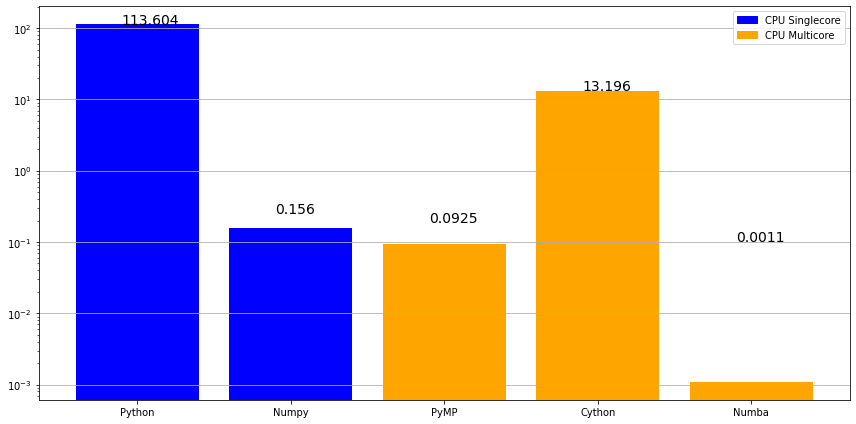

In [111]:
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
# Create arrays for the plot
version = ['Python', 'Numpy', 'PyMP', 'Cython', 'Numba']
c = ['blue', 'blue', 'orange', 'orange', 'orange', 'orange']
x_pos = np.arange(len(version))
time = [time_python.best, time_numpy.best, time_pymp.best, time_cython.best, time_numba.best]

colors = {'CPU Singlecore':'blue', 'CPU Multicore':'orange'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, time, align='center', color=c)
ax.legend(handles, labels)
# ax.set_ylabel('Time in seconds')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.set_xticks(x_pos)
ax.set_xticklabels(version)
#ax.set_title('Benchmark of Accelerating Soft-supervised training algorithm')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# Text on the top of each bar
for index,data in enumerate(time):
    plt.text(x=index-0.1 , y =data+0.1 , s=f"{round(data,4)}" , fontdict=dict(fontsize=14))
#plt.savefig('bm_results1.eps') # Uncomment if want to save file
plt.show()


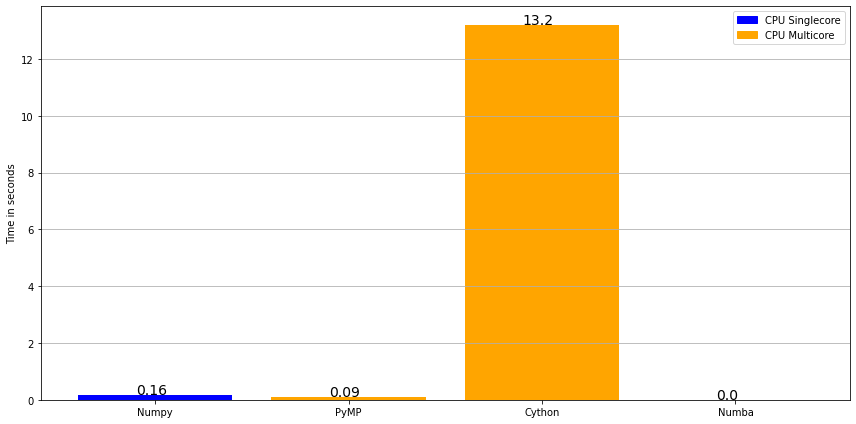

In [102]:
# Create arrays for the plot
version = ['Numpy', 'PyMP', 'Cython', 'Numba']
c = ['blue', 'orange', 'orange', 'orange', 'orange']
x_pos = np.arange(len(version))
time = [time_numpy.best, time_pymp.best, time_cython.best, time_numba.best]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, time, align='center', color=c)
ax.legend(handles, labels)
ax.set_ylabel('Time in seconds')
ax.set_xticks(x_pos)
ax.set_xticklabels(version)
#ax.set_title('Benchmark of Accelerating Euclidean-distance algorithm')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# Text on the top of each bar
for index,data in enumerate(time):
    plt.text(x=index-0.1 , y =data+0.025 , s=f"{round(data,2)}" , fontdict=dict(fontsize=14))
#plt.savefig('bm_results2.eps') # Uncomment if want to save file
plt.show()

## 8. Benchmarking: More cores equals more speed? <a name="benchmarking"></a>


We've carried out a benchmark involving a range of matrix sizes and experimented with different thread configurations. The benchmark script has been run (please note, it takes some time to complete), and the results are tabulated below for your reference. The row index corresponds to the matrix sizes, while the column names specify the library used and, where applicable, the number of threads employed.


We integrated Numba into our benchmark and observed that, compared to other implementations, it consistently delivers the fastest execution times. Furthermore, transitioning to Numba from existing Numpy code demands minimal effort—typically involving the addition of decorators and parallel loops to your existing codebase. This streamlined integration process makes it an attractive choice for optimizing performance in computationally intensive tasks.

To do this we are going to install pandas:

In [112]:
!pip install pandas

/usr/lib64/python3.6/pty.py:84: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1a8dcc84c0>
  pid, fd = os.forkpty()


In [113]:
import pandas as pd

df_mp = pd.read_csv("exp_mp_results_tmp.csv", index_col=0)
#df_mp = df_mp.round(2)


# Display the rounded DataFrame with four decimal places
#pd.options.display.float_format = '{:.2f}'.format

# Function to highlight the minimum value in each row with green
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Function to highlight the maximum value in each row with light red
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightcoral' if v else '' for v in is_max]

# Apply the functions when displaying the DataFrame
df_mp.style.apply(highlight_min, axis=1).apply(highlight_max, axis=1)

,Numpy,Numba,mp-5,omp-5,mp-10,omp-10,mp-25,omp-25,mp-50,omp-50,mp-75,omp-75,mp-100,omp-100,mp-128,omp-128
500,0.116011,3.520831,0.137670,0.157743,0.145944,0.096620,0.282051,0.167511,0.545277,0.321402,0.844989,0.453545,1.023236,0.626578,1.493435,0.967613
750,0.391915,0.027157,0.212928,0.156760,0.395949,0.172345,0.721723,0.260546,1.185418,0.426208,1.540071,0.649957,2.092115,0.843256,2.411329,1.043764
1000,1.162880,0.034632,0.581376,0.411880,0.844506,0.560587,1.434834,0.729913,2.284875,0.585020,2.835173,0.715960,4.256610,0.882953,5.325395,1.056091
2000,16.265693,0.659489,5.715396,10.809903,7.582666,10.809522,7.172268,6.397843,11.037036,3.986869,14.270160,4.978332,18.856412,4.289192,21.001495,4.142219
3000,106.099317,4.032562,24.202048,27.738913,15.452698,19.879130,16.224219,14.900778,27.765554,13.943448,39.258814,12.244166,47.628625,11.886112,61.428592,11.636307
4000,257.627519,15.178899,55.220637,70.736810,34.266264,52.678350,29.506797,41.071929,48.830895,35.835644,66.413042,30.969884,88.801758,29.902541,108.759893,29.204521
5000,473.284437,35.974558,109.391353,137.631153,61.632718,109.967156,47.002877,81.345335,75.248583,71.275931,105.150151,68.974435,133.340773,61.052349,166.688686,56.888782
6000,771.704710,67.271954,176.593494,220.627649,111.882182,186.854354,69.991616,148.784920,111.474942,124.870872,154.211084,108.003705,199.113434,108.212263,242.325562,107.949042
7000,1320.583204,102.126062,275.767237,322.662790,168.717223,248.197016,102.343567,193.199911,155.601697,157.293951,209.424539,139.022700,262.022139,119.134413,330.991728,106.628269
8000,1853.721335,140.660250,411.458420,495.115393,241.471038,342.293787,144.260237,254.458351,203.469478,212.393791,275.553274,168.253051,348.550182,157.205038,433.030346,161.712262


We've marked the fastest execution in green and the slowest in red.

As we can see in this case, having more cores doesn't necessarily translate to greater speed. Utilizing parallelization techniques introduces overhead, as evidenced by the fact that using 128 cores with smaller matrix sizes results in the poorest execution speed.

After matrices are of size 3,000 or larger NumPy is always slower than using multiprocessing with any number of threads.

After matrices are of size 4,000 or larger using 25 threads yields the fastest execution speed.


## 9. Conclusions / take away<a name="conclusions"></a>

Important note: keep in mind that the results presented in this notebook are for a specific use case. Different scenarios may yield varying results, and alternate approaches, such as multiprocessing or PyMP, may prove more effective in certain contexts. There is no one-size-fits-all solution. 


- Starting with Numba is a recommended practice due to its minimal time investment requirement and potential for performance optimization.
- Cython also offers a very good speedup, compared to Numpy. However, we can observe that Numpy and Numba's implementation is not only simpler but also more readable than its Cython counterpart.

<table>
<tr>
<th style="text-align: center;" width="50%">Numpy</th>
<th style="text-align: center;" width="50%">Cython</th>
</tr>
<tr>
<td style="text-align: left;">
    
```python
def edistance_3(matrix1, matrix2):
    output = np.zeros((A.shape[0], B.shape[0]))
    for i, row1 in enumerate(matrix1):
        output[i] = np.sqrt(np.sum((row1 - matrix2)**2, axis=1))
    return output
```
</td>
<td style="text-align: left;">

```python
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef edistance_5(double[:,:] matrix1, double[:,:] matrix2):
    cdef int i, j, k
    cdef int I = matrix1.shape[0]
    cdef int J = matrix2.shape[0]
    cdef int K = matrix1.shape[1]
    cdef np.ndarray distances = np.zeros((matrix1.shape[0], matrix2.shape[0]))
    cdef double[:,:] distances_mv = distances # memory view
    cdef double res_1, res_2

    for i in range(I): # Iterate over matrix1 rows
        for j in prange(J, nogil=True): #Iterate over rows of matrix2
            distances_mv[i, j] = 0.0
            for k in range(K): # Iterate over columns of matrix1 and matrix2
                res_1 = matrix1[i, k] - matrix2[j, k] # Get difference
                res_2 = res_1 ** 2 # Get squared difference
                distances_mv[i, j] += res_2
            distances_mv[i, j] = sqrt(distances_mv[i, j])
    return distances
```

</td>
</tr>
</table>

- Multiprocessing and PyMP are programed more or less similar, but with some important differences. For example, multiprocessing spawns processes and PyMP uses threads. Additionally, multiprocessing offers a more extensive documentation compared to PyMP.